<a href="https://colab.research.google.com/github/Harshithaukp/Tree_Count/blob/main/Tree_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision numpy scipy rasterio opencv-python matplotlib scikit-image


In [79]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.cuda import amp # Import for Automatic Mixed Precision

In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os

base_drive = "/content/drive/MyDrive/Bangalore_Trees_Project"
print(os.listdir(base_drive))


['bangalore_tile_10.jpg', 'bangalore_tile_43.jpg', 'bangalore_tile_14.jpg', 'bangalore_tile_35.jpg', 'bangalore_tile_16.jpg', 'bangalore_tile_24.jpg', 'bangalore_tile_47.jpg', 'bangalore_tile_40.jpg', 'bangalore_tile_26.jpg', 'bangalore_tile_15.jpg', 'bangalore_tile_22.jpg', 'bangalore_tile_29.jpg', 'bangalore_tile_17.jpg', 'bangalore_tile_42.jpg', 'bangalore_tile_9.jpg', 'bangalore_tile_21.jpg', 'bangalore_tile_4.jpg', 'bangalore_tile_41.jpg', 'bangalore_tile_7.jpg', 'bangalore_tile_44.jpg', 'bangalore_tile_27.jpg', 'bangalore_tile_48.jpg', 'bangalore_tile_8.jpg', 'bangalore_tile_11.jpg', 'bangalore_tile_13.jpg', 'bangalore_tile_38.jpg', 'bangalore_tile_37.jpg', 'bangalore_tile_2.jpg', 'bangalore_tile_25.jpg', 'bangalore_tile_19.jpg', 'bangalore_tile_1.jpg', 'bangalore_tile_28.jpg', 'bangalore_tile_23.jpg', 'bangalore_tile_6.jpg', 'tile_3.csv', 'tile_12.csv', 'tile_30 .csv', 'tile_3 .csv', 'tile_31.csv', 'tile_18.csv', 'tile_32.csv', 'tile_36.csv', 'tile_39.csv', 'tile_20.csv', 'tile_

In [18]:
os.makedirs("/content/data/images_all", exist_ok=True)
os.makedirs("/content/data/images_labeled", exist_ok=True)
os.makedirs("/content/data/csvs", exist_ok=True)


In [19]:
import shutil
import glob

image_files = glob.glob(base_drive + "/bangalore_tile_*.jpg")

print("Found images:", len(image_files))

for img_path in image_files:
    shutil.copy(img_path, "/content/data/images_all/")


Found images: 49


In [25]:
csv_files = glob.glob(base_drive + "/tile_*.csv")

print("Found CSVs:", len(csv_files))

for csv_path in csv_files:
    shutil.copy(csv_path, "/content/data/csvs/")


Found CSVs: 14


In [26]:
for csv_file in os.listdir("/content/data/csvs"):
    tile_id = csv_file.replace("tile_", "").replace(".csv", "")
    img_name = f"bangalore_tile_{tile_id}.jpg"

    src_img = f"/content/data/images_all/{img_name}"
    dst_img = f"/content/data/images_labeled/{img_name}"

    if os.path.exists(src_img):
        shutil.copy(src_img, dst_img)
    else:
        print("Missing image for:", csv_file)


Missing image for: tile_30 .csv
Missing image for: tile_3 .csv
Missing image for: tile_5_t.csv
Missing image for: tile_33_tree.csv
Missing image for: tile_30 (1).csv
Missing image for: tile_3 (1).csv


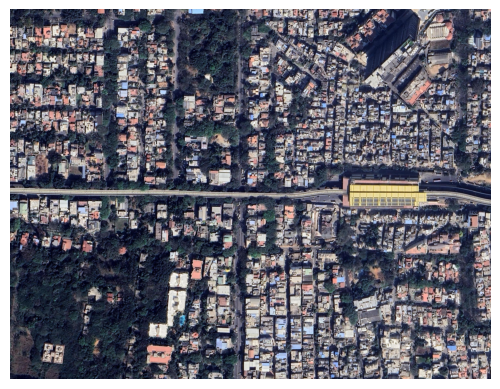

(2295, 2983, 3)


In [27]:
import cv2
import matplotlib.pyplot as plt

test_img = "/content/data/images_labeled/bangalore_tile_3.jpg"

img = cv2.imread(test_img)
if img is None:
    raise ValueError("Image not found")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0

plt.imshow(img)
plt.axis("off")
plt.show()

print(img.shape)


In [28]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter


In [30]:
csv_path = "/content/data/csvs/tile_3.csv"
df = pd.read_csv(csv_path)

# Assuming 'field_1' is x and 'field_2' is y based on the kernel state
points = df[['field_1', 'field_2']].values
H, W, _ = img.shape

density = np.zeros((H, W), dtype=np.float32)

for x, y in points:
    x, y = int(x), int(y)
    if 0 <= x < W and 0 <= y < H:
        density[y, x] += 1

density = gaussian_filter(density, sigma=2)

In [31]:
print("Trees:", len(points))
print("Density sum:", density.sum())


Trees: 566
Density sum: 0.0


In [33]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

img = cv2.imread("/content/data/images_labeled/bangalore_tile_49.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0

H, W, _ = img.shape
print(H, W)  # should be 2297, 2610


2297 2610


In [35]:
df = pd.read_csv("/content/data/csvs/tile_49.csv")
points = df[['X', 'Y']].values

print("Trees:", len(points))
print(points[:5])

Trees: 651
[[  199.87144202 -2245.45587349]
 [   21.88853539 -2066.56489081]
 [   23.7046875  -2094.71524849]
 [  123.59305346 -2068.38104292]
 [   34.60160015 -1981.20574172]]


In [36]:
density = np.zeros((H, W), dtype=np.float32)

for x, y in points:
    px = int(x)
    py = int(-y)   # THIS IS THE FIX

    if 0 <= px < W and 0 <= py < H:
        density[py, px] += 1

density = gaussian_filter(density, sigma=2)


In [37]:
print("Trees:", len(points))
print("Density sum:", density.sum())


Trees: 651
Density sum: 650.9999


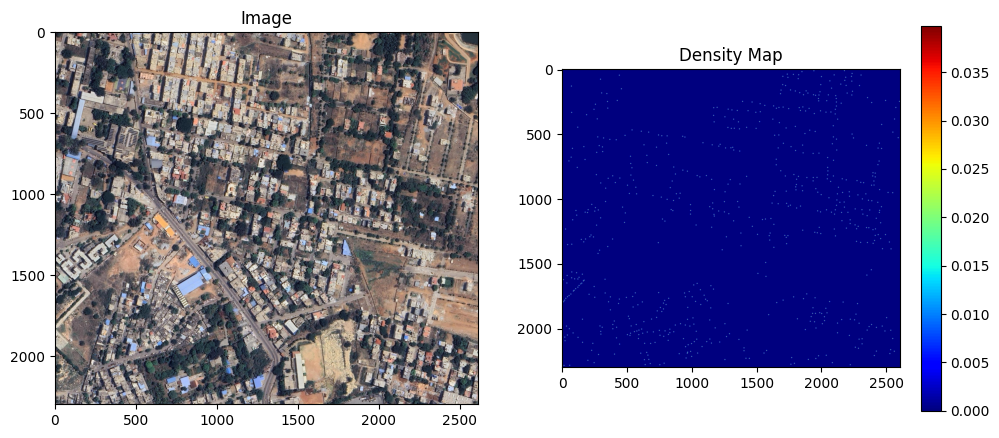

In [38]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(density, cmap="jet")
plt.title("Density Map")
plt.colorbar()

plt.show()


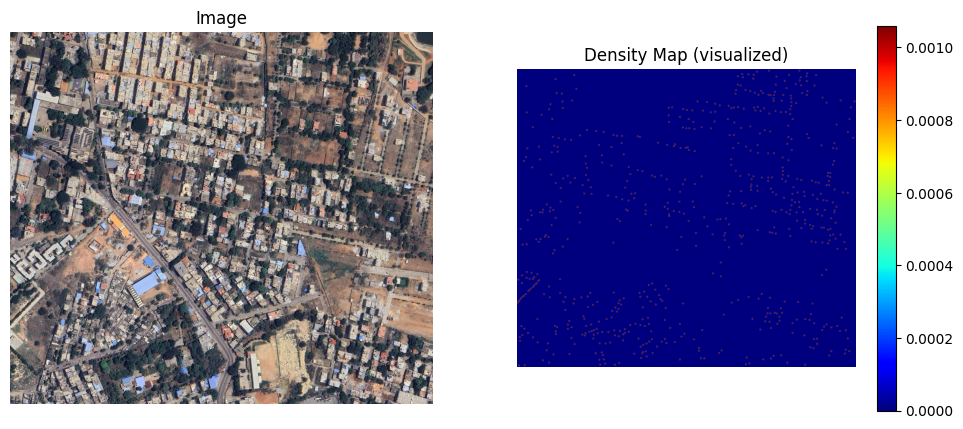

In [39]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(
    density,
    cmap="jet",
    vmax=np.percentile(density, 99)  # KEY LINE
)
plt.title("Density Map (visualized)")
plt.colorbar()
plt.axis("off")

plt.show()


In [40]:
density = gaussian_filter(density, sigma=4)


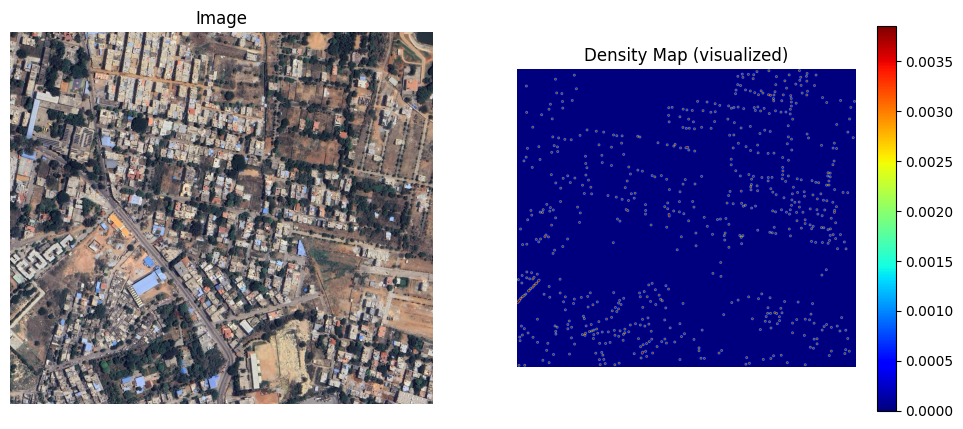

In [41]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(
    density,
    cmap="jet",
    vmax=np.percentile(density, 99)  # KEY LINE
)
plt.title("Density Map (visualized)")
plt.colorbar()
plt.axis("off")

plt.show()

In [42]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


In [50]:
import pandas as pd

csv_test = "/content/data/csvs/tile_49.csv"
df = pd.read_csv(csv_test)

print(df.columns)
print(df.head())


Index(['X', 'Y', 'id'], dtype='object')
            X            Y  id
0  199.871442 -2245.455873 NaN
1   21.888535 -2066.564891 NaN
2   23.704687 -2094.715248 NaN
3  123.593053 -2068.381043 NaN
4   34.601600 -1981.205742 NaN


In [76]:
class TreeDensityDataset(Dataset):
    def __init__(self, img_dir, csv_dir, sigma=2, resize_scale=None):
        self.img_dir = img_dir
        self.csv_dir = csv_dir
        self.sigma = sigma
        self.resize_scale = resize_scale
        self.data_items = []  # To store valid (image_name, csv_path, x_col, y_col) tuples

        x_candidates = ['x', 'xcoord', 'x_coordinate', 'longitude', 'lon', 'field_1', 'x']
        y_candidates = ['y', 'ycoord', 'y_coordinate', 'latitude', 'lat', 'field_2', 'y']

        # Pre-process to find valid image-CSV pairs
        for img_name in sorted(os.listdir(img_dir)):
            if not img_name.endswith('.jpg'):
                continue

            tile_id = img_name.replace("bangalore_tile_", "").replace(".jpg", "")
            csv_path = os.path.join(self.csv_dir, f"tile_{tile_id}.csv")

            if not os.path.exists(csv_path):
                print(f"Warning: Missing CSV for image {img_name}. Skipping.")
                continue

            try:
                df = pd.read_csv(csv_path)
                # Normalize column names to lowercase and strip whitespace
                df.columns = df.columns.str.lower().str.strip()

                x_col = next((c for c in x_candidates if c in df.columns), None)
                y_col = next((c for c in y_candidates if c in df.columns), None)

                if x_col is None or y_col is None:
                    print(f"Warning: CSV {csv_path} missing x/y columns. Found: {df.columns.tolist()}. Skipping.")
                    continue

                # If we reach here, both image and CSV are valid and columns are identified
                self.data_items.append((img_name, csv_path, x_col, y_col))

            except Exception as e:
                print(f"Error processing {csv_path}: {e}. Skipping.")
                continue

    def __len__(self):
        return len(self.data_items)

    def __getitem__(self, idx):
        img_name, csv_path, x_col, y_col = self.data_items[idx]

        # Load image
        img = cv2.imread(os.path.join(self.img_dir, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0

        # Load CSV
        df = pd.read_csv(csv_path)
        # Ensure columns are normalized again for consistency, though should be fine due to pre-filtering
        df.columns = df.columns.str.lower().str.strip()
        points = df[[x_col, y_col]].values

        # Apply resizing if resize_scale is provided
        original_H, original_W, _ = img.shape
        if self.resize_scale:
            new_W = int(original_W * self.resize_scale)
            new_H = int(original_H * self.resize_scale)
            img = cv2.resize(img, (new_W, new_H), interpolation=cv2.INTER_AREA)
            # Scale point coordinates as well
            points[:, 0] = points[:, 0] * self.resize_scale  # X coordinates
            points[:, 1] = points[:, 1] * self.resize_scale  # Y coordinates
            H, W = new_W, new_H
            sigma = self.sigma * self.resize_scale  # Scale sigma proportionally
        else:
            H, W = original_H, original_W
            sigma = self.sigma

        # Build density map
        density = np.zeros((H, W), dtype=np.float32)

        for x, y in points:
            px = int(x)
            py = int(-y)  # IMPORTANT: same fix as tile_49

            if 0 <= px < W and 0 <= py < H:
                density[py, px] += 1

        density = gaussian_filter(density, sigma=sigma)

        # Torch tensors
        img = torch.tensor(img).permute(2, 0, 1).float()
        density = torch.tensor(density).unsqueeze(0).float()

        return img, density

In [71]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def block(a, b):
            return nn.Sequential(
                nn.Conv2d(a, b, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(b, b, 3, padding=1),
                nn.ReLU()
            )

        self.d1 = block(3, 64)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = block(64, 128)
        self.p2 = nn.MaxPool2d(2)

        self.mid = block(128, 256)

        self.u2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.c2 = block(256, 128)

        self.u1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.c1 = block(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(self.p1(d1))
        m = self.mid(self.p2(d2))

        # Upsample m and crop d2 to match before concatenating
        up_output_2 = self.u2(m)
        target_height_2 = up_output_2.shape[2]
        target_width_2 = up_output_2.shape[3]
        d2_cropped = d2[:, :, :target_height_2, :target_width_2]
        u2 = self.c2(torch.cat([up_output_2, d2_cropped], dim=1))

        # Upsample u2 and crop d1 to match before concatenating
        up_output_1 = self.u1(u2)
        target_height_1 = up_output_1.shape[2]
        target_width_1 = up_output_1.shape[3]
        d1_cropped = d1[:, :, :target_height_1, :target_width_1]
        u1 = self.c1(torch.cat([up_output_1, d1_cropped], dim=1))

        return self.out(u1)

In [81]:
dataset = TreeDensityDataset(
    img_dir="/content/data/images_labeled",
    csv_dir="/content/data/csvs",
    sigma=2,
    resize_scale=0.125 # Further reduced resize_scale to reduce memory usage
)

loader = DataLoader(dataset, batch_size=1, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [82]:
epochs = 80 # Define epochs if not already defined

scaler = amp.GradScaler() # Initialize GradScaler for mixed precision

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for img, dens in loader:
        img = img.to(device)
        dens = dens.to(device)

        optimizer.zero_grad()

        with amp.autocast(): # Enable autocast for mixed precision
            pred = model(img)

            # Resize dens to match pred's spatial dimensions
            if pred.shape[2:] != dens.shape[2:]:
                dens = F.interpolate(dens, size=pred.shape[2:], mode='bilinear', align_corners=False)

            loss = loss_fn(pred, dens)

        scaler.scale(loss).backward() # Scale loss and perform backward pass
        scaler.step(optimizer) # Update optimizer
        scaler.update() # Update scaler

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss {epoch_loss/len(loader):.6f}")

/tmp/ipython-input-681316752.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler() # Initialize GradScaler for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Pleas

Epoch 1/80 | Loss 0.002523


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 2/80 | Loss 0.002503


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 3/80 | Loss 0.002482


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 4/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 5/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 6/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 7/80 | Loss 0.002471


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 8/80 | Loss 0.002472


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 9/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 10/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 11/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 12/80 | Loss 0.002471


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 13/80 | Loss 0.002472


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 14/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 15/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 16/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 17/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 18/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 19/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 20/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 21/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 22/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 23/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 24/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 25/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 26/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 27/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 28/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 29/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 30/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 31/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 32/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 33/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 34/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 35/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 36/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 37/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 38/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 39/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 40/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 41/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 42/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 43/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 44/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 45/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 46/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 47/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 48/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 49/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 50/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 51/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 52/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 53/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 54/80 | Loss 0.002471


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 55/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 56/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 57/80 | Loss 0.002469


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 58/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 59/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 60/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 61/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 62/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 63/80 | Loss 0.002466


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 64/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 65/80 | Loss 0.002466


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 66/80 | Loss 0.002470


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 67/80 | Loss 0.002466


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 68/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 69/80 | Loss 0.002468


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 70/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 71/80 | Loss 0.002466


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 72/80 | Loss 0.002466


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 73/80 | Loss 0.002466


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 74/80 | Loss 0.002466


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 75/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 76/80 | Loss 0.002467


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 77/80 | Loss 0.002466


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 78/80 | Loss 0.002466


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 79/80 | Loss 0.002466


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision
/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.a

Epoch 80/80 | Loss 0.002472


/tmp/ipython-input-681316752.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(): # Enable autocast for mixed precision


In [83]:
torch.save(model.state_dict(), "/content/tree_density_unet.pth")
print("Model saved")


Model saved


In [84]:
from google.colab import files
files.download("/content/tree_density_unet.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
model.eval()

import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

img_path = "/content/data/images_labeled/bangalore_tile_49.jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
img_norm = img / 255.0

tensor = torch.tensor(img_norm).permute(2,0,1).unsqueeze(0).float().to(device)

with torch.no_grad():
    pred_density = model(tensor)[0,0].cpu().numpy()

print("Predicted trees:", pred_density.sum())


Predicted trees: 168.21234


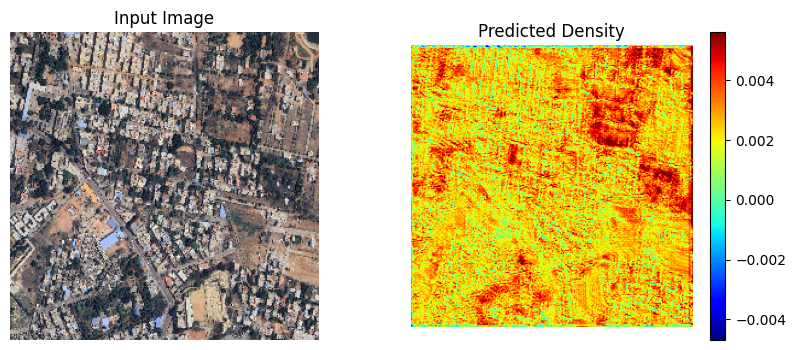

In [86]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_density, cmap="jet", vmax=np.percentile(pred_density, 99))
plt.title("Predicted Density")
plt.colorbar()
plt.axis("off")

plt.show()


In [87]:
from skimage.feature import peak_local_max

points = peak_local_max(
    pred_density,
    min_distance=6,
    threshold_abs=0.01
)

print("Detected trees:", len(points))


Detected trees: 0


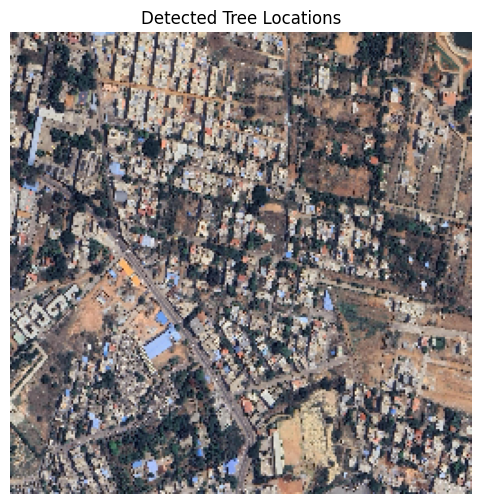

In [88]:
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.scatter(points[:,1], points[:,0], s=6, c="red")
plt.title("Detected Tree Locations")
plt.axis("off")
plt.show()


In [89]:
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter

# Post-process density
density_pp = pred_density.copy()
density_pp[density_pp < 0] = 0
density_pp = gaussian_filter(density_pp, sigma=1)

# Adaptive threshold
thr = 0.3 * density_pp.max()

points = peak_local_max(
    density_pp,
    min_distance=6,
    threshold_abs=thr
)

print("Detected trees:", len(points))


Detected trees: 192


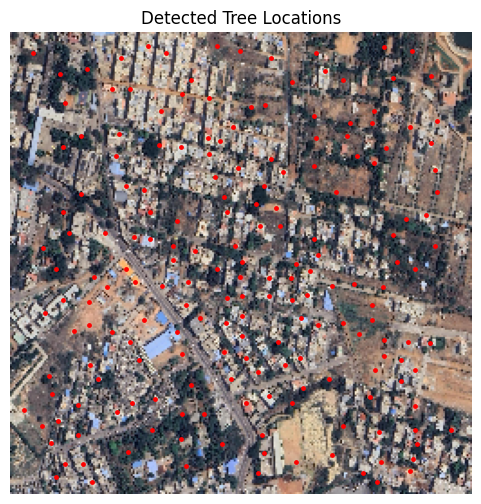

In [90]:
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.scatter(points[:,1], points[:,0], s=6, c="red")
plt.title("Detected Tree Locations")
plt.axis("off")
plt.show()


In [91]:
test_img = "/content/data/images_all/bangalore_tile_10.jpg"

img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
img_norm = img / 255.0

tensor = torch.tensor(img_norm).permute(2,0,1).unsqueeze(0).float().to(device)

with torch.no_grad():
    density = model(tensor)[0,0].cpu().numpy()

print("Predicted trees:", density.sum())


Predicted trees: 146.57835


In [92]:
def sliding_window_density(model, image, tile=256, overlap=0.25):
    H, W, _ = image.shape
    stride = int(tile * (1 - overlap))

    density_full = np.zeros((H, W), dtype=np.float32)
    weight = np.zeros((H, W), dtype=np.float32)

    for y in range(0, H - tile + 1, stride):
        for x in range(0, W - tile + 1, stride):
            patch = image[y:y+tile, x:x+tile]
            patch = patch / 255.0

            tensor = torch.tensor(patch).permute(2,0,1).unsqueeze(0).float().to(device)

            with torch.no_grad():
                pred = model(tensor)[0,0].cpu().numpy()

            density_full[y:y+tile, x:x+tile] += pred
            weight[y:y+tile, x:x+tile] += 1

    return density_full / np.maximum(weight, 1)


In [93]:
big_img = cv2.imread("/content/data/images_all/bangalore_tile_10.jpg")
big_img = cv2.cvtColor(big_img, cv2.COLOR_BGR2RGB)

density_big = sliding_window_density(model, big_img)

print("Total trees:", density_big.sum())


Total trees: 13155.043


In [94]:
points_big = peak_local_max(density_big, min_distance=6, threshold_abs=0.01)

import pandas as pd
df_points = pd.DataFrame({
    "x": points_big[:,1],
    "y": points_big[:,0]
})

df_points.to_csv("predicted_tree_points.csv", index=False)


In [101]:
import streamlit as st
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
import os
import torch.nn as nn

# Re-define UNet class (copied from 4pg-tY9NF-KP)
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def block(a, b):
            return nn.Sequential(
                nn.Conv2d(a, b, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(b, b, 3, padding=1),
                nn.ReLU()
            )

        self.d1 = block(3, 64)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = block(64, 128)
        self.p2 = nn.MaxPool2d(2)

        self.mid = block(128, 256)

        self.u2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.c2 = block(256, 128)

        self.u1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.c1 = block(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(self.p1(d1))
        m = self.mid(self.p2(d2))

        # Upsample m and crop d2 to match before concatenating
        up_output_2 = self.u2(m)
        target_height_2 = up_output_2.shape[2]
        target_width_2 = up_output_2.shape[3]
        d2_cropped = d2[:, :, :target_height_2, :target_width_2]
        u2 = self.c2(torch.cat([up_output_2, d2_cropped], dim=1))

        # Upsample u2 and crop d1 to match before concatenating
        up_output_1 = self.u1(u2)
        target_height_1 = up_output_1.shape[2]
        target_width_1 = up_output_1.shape[3]
        d1_cropped = d1[:, :, :target_height_1, :target_width_1]
        u1 = self.c1(torch.cat([up_output_1, d1_cropped], dim=1))

        return self.out(u1)


# Create the app.py file
app_code = """
import streamlit as st
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
import torch.nn as nn

# Re-define UNet class as it's needed by the model loading function
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def block(a, b):
            return nn.Sequential(
                nn.Conv2d(a, b, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(b, b, 3, padding=1),
                nn.ReLU()
            )

        self.d1 = block(3, 64)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = block(64, 128)
        self.p2 = nn.MaxPool2d(2)

        self.mid = block(128, 256)

        self.u2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.c2 = block(256, 128)

        self.u1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.c1 = block(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(self.p1(d1))
        m = self.mid(self.p2(d2))

        up_output_2 = self.u2(m)
        target_height_2 = up_output_2.shape[2]
        target_width_2 = up_output_2.shape[3]
        d2_cropped = d2[:, :, :target_height_2, :target_width_2]
        u2 = self.c2(torch.cat([up_output_2, d2_cropped], dim=1))

        up_output_1 = self.u1(u2)
        target_height_1 = up_output_1.shape[2]
        target_width_1 = up_output_1.shape[3]
        d1_cropped = d1[:, :, :target_height_1, :target_width_1]
        u1 = self.c1(torch.cat([up_output_1, d1_cropped], dim=1))

        return self.out(u1)


@st.cache_resource
def load_model():
    model = UNet()
    # Ensure the path to the model checkpoint is correct
    model.load_state_dict(torch.load("tree_density_unet.pth", map_location="cpu"))
    model.eval()
    return model

model = load_model()

st.title("Urban Tree Counter")

uploaded_file = st.file_uploader("Upload satellite image", type=["jpg","png"])

if uploaded_file is not None:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (256,256))
    tensor = torch.tensor(img_resized/255.0).permute(2,0,1).unsqueeze(0).float()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    tensor = tensor.to(device)

    with torch.no_grad():
        density = model(tensor)[0,0].cpu().numpy()

    count = density.sum()
    st.subheader(f"Estimated Trees: {int(count)}")

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(img_resized)
    ax[0].set_title("Input")
    ax[0].axis("off")

    ax[1].imshow(density, cmap="jet", vmax=np.percentile(density, 99))
    ax[1].set_title("Density")
    ax[1].axis("off")

    st.pyplot(fig)
"""

with open("app.py", "w") as f:
    f.write(app_code)

print("app.py created successfully!")

app.py created successfully!


In [97]:
@st.cache_resource
def load_model():
    model = UNet()
    model.load_state_dict(torch.load("tree_density_unet.pth", map_location="cpu"))
    model.eval()
    return model

model = load_model()


2025-12-23 08:04:24.729 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:04:24.802 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-12-23 08:04:24.802 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:04:24.803 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:04:24.805 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:04:24.831 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:04:24.831 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:04:24.832 Thread 'MainThread': mi

In [98]:
st.title("Urban Tree Counter")

uploaded = st.file_uploader("Upload satellite image", type=["jpg","png"])

if uploaded:
    file_bytes = np.asarray(bytearray(uploaded.read()), dtype=np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (256,256))
    tensor = torch.tensor(img_resized/255.0).permute(2,0,1).unsqueeze(0).float()

    with torch.no_grad():
        density = model(tensor)[0,0].numpy()

    count = density.sum()
    st.subheader(f"Estimated Trees: {int(count)}")

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].imshow(img_resized)
    ax[0].set_title("Input")
    ax[0].axis("off")

    ax[1].imshow(density, cmap="jet", vmax=np.percentile(density, 99))
    ax[1].set_title("Density")
    ax[1].axis("off")

    st.pyplot(fig)


2025-12-23 08:05:00.525 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:05:00.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:05:00.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:05:00.532 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:05:00.534 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:05:00.535 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:05:00.540 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-23 08:05:00.541 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [103]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.169.219.142:8501

  Stopping...
  Stopping...


In [104]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max


In [105]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def block(a, b):
            return nn.Sequential(
                nn.Conv2d(a, b, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(b, b, 3, padding=1),
                nn.ReLU()
            )

        self.d1 = block(3, 64)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = block(64, 128)
        self.p2 = nn.MaxPool2d(2)

        self.mid = block(128, 256)

        self.u2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.c2 = block(256, 128)

        self.u1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.c1 = block(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(self.p1(d1))
        m = self.mid(self.p2(d2))
        u2 = self.c2(torch.cat([self.u2(m), d2], dim=1))
        u1 = self.c1(torch.cat([self.u1(u2), d1], dim=1))
        return self.out(u1)


In [106]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet().to(device)
model.load_state_dict(torch.load("tree_density_unet.pth", map_location=device))
model.eval()


UNet(
  (d1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mid): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (u2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (c2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 

In [107]:
def predict_tree_density(image):
    # image comes as RGB numpy array
    orig_img = image.copy()

    # Resize to model input
    img = cv2.resize(image, (256, 256))
    img_norm = img / 255.0

    tensor = torch.tensor(img_norm).permute(2,0,1).unsqueeze(0).float().to(device)

    with torch.no_grad():
        density = model(tensor)[0,0].cpu().numpy()

    # ---- Post-processing ----
    density[density < 0] = 0
    density = gaussian_filter(density, sigma=1)

    tree_count = int(density.sum())

    # ---- Peak detection ----
    threshold = 0.3 * density.max()
    points = peak_local_max(
        density,
        min_distance=6,
        threshold_abs=threshold
    )

    # ---- Visualization ----
    # Density map
    fig1, ax1 = plt.subplots()
    ax1.imshow(density, cmap="jet", vmax=np.percentile(density, 99))
    ax1.set_title("Density Map")
    ax1.axis("off")

    # Tree points overlay
    fig2, ax2 = plt.subplots()
    ax2.imshow(img)
    ax2.scatter(points[:,1], points[:,0], s=6, c="red")
    ax2.set_title("Detected Trees")
    ax2.axis("off")

    return tree_count, fig1, fig2


In [108]:
import gradio as gr

interface = gr.Interface(
    fn=predict_tree_density,
    inputs=gr.Image(type="numpy", label="Upload Satellite Image"),
    outputs=[
        gr.Number(label="Estimated Number of Trees"),
        gr.Plot(label="Predicted Density Map"),
        gr.Plot(label="Detected Tree Locations")
    ],
    title="Urban Tree Counting (Density Map Based)",
    description="Upload a satellite image. The model predicts tree density and tree locations using a CNN-based density regression approach."
)


In [109]:
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://56e9343f4e415479f6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
